In [155]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [156]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [157]:
NUM_CLASSES = 6

# Dataset reading

In [158]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [159]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [161]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [162]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [163]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [164]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [165]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/4 [======>.......................] - ETA: 1s - loss: 1.9273 - accuracy: 0.1406
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
4/4 [==============================] - 1s 77ms/step - loss: 1.8899 - accuracy: 0.1771 - val_loss: 1.6824 - val_accuracy: 0.2108
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 1.7699 - accuracy: 0.2109
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
4/4 [==============================] - 0s 26ms/step - loss: 1.7858 - accuracy: 0.1771 - val_loss: 1.6430 - val_accuracy: 0.3012
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 1.7966 - accuracy: 0.1797
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
4/4 [==============================] - 0s 27ms/step - loss: 1.7625 - accuracy: 0.1932 - val_loss: 1.6155 - val_accuracy: 0.3614
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 1.7167 - accuracy: 0.1641
Epoch 4: sav

In [166]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 4ms/step - loss: 0.2403 - accuracy: 0.9398


In [167]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [168]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[3.3957178e-05 9.9856550e-01 5.2643587e-05 8.9653622e-04 4.5154899e-04]
1


# Confusion matrix

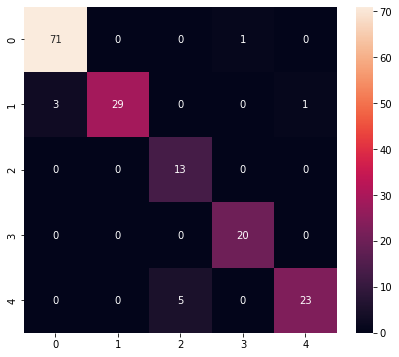

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       1.00      0.88      0.94        33
           2       0.72      1.00      0.84        13
           3       0.95      1.00      0.98        20
           4       0.96      0.82      0.88        28

    accuracy                           0.94       166
   macro avg       0.92      0.94      0.92       166
weighted avg       0.95      0.94      0.94       166



In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [170]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [171]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpgqq__59b/assets


INFO:tensorflow:Assets written to: /tmp/tmpgqq__59b/assets
2022-05-02 15:52:49.822924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-02 15:52:49.822971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-02 15:52:49.823230: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpgqq__59b
2022-05-02 15:52:49.825022: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-02 15:52:49.825058: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpgqq__59b
2022-05-02 15:52:49.830733: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-02 15:52:49.891864: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpgqq__59b
2022-05-02 15:52:49.915323: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

6512

# Inference test

In [172]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [173]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [174]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [175]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 0 ns, sys: 1.36 ms, total: 1.36 ms
Wall time: 1.04 ms


In [176]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.3957171e-05 9.9856538e-01 5.2643423e-05 8.9653529e-04 4.5154803e-04]
1
